# Geography
In the previous tutorial ([Running a query](02-running-a-query.ipynb)), you learned how to run a FlowKit query, and get the result as a pandas dataframe.

In this tutorial you will learn:

- Options for the 'aggregation_unit' parameter  
- How to get a query result as geojson  
- How to get a separate geojson containing the geography (and why you might want to do this)

In [1]:
import flowclient as fc
import geopandas as gpd

In [2]:
token = 

conn = fc.connect(
    url="https://api.flowcloud-ghana.flowminder.org",
    token=token,
)

In [12]:
subscriber_counts_query = fc.unique_subscriber_counts(
    connection=conn,
    start_date="2016-01-01",
    end_date="2016-01-02",
    aggregation_unit="admin2",
)

In [32]:
subscriber_counts_query_result_geojson = subscriber_counts_query.get_result(format="geojson")

In [33]:
type(subscriber_counts_query_result_geojson)

dict

In [34]:
subscriber_counts_query_result_geopandas = gpd.GeoDataFrame.from_features(subscriber_counts_query_result_geojson)

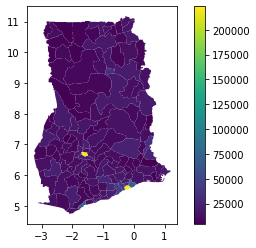

In [35]:
subscriber_counts_query_result_geopandas.plot(column="value", legend=True)

In [8]:
admin2_geojson = fc.get_geography(connection=conn, aggregation_unit="admin2")
admin2_geopandas = gpd.GeoDataFrame.from_features(admin2_geojson)
admin2_geopandas

,geometry,pcod,centroid
0,"MULTIPOLYGON (((-1.41637 6.32333, -1.43242 6.3...",GHA.1.1_1,"{'type': 'Point', 'coordinates': [-1.585607706..."
1,"MULTIPOLYGON (((-1.54145 5.93492, -1.53550 5.9...",GHA.1.2_1,"{'type': 'Point', 'coordinates': [-1.394701237..."
2,"MULTIPOLYGON (((-1.41025 6.86558, -1.42795 6.8...",GHA.1.3_1,"{'type': 'Point', 'coordinates': [-1.557937016..."
3,"MULTIPOLYGON (((-2.29597 6.71882, -2.29462 6.7...",GHA.1.4_1,"{'type': 'Point', 'coordinates': [-2.201639978..."
4,"MULTIPOLYGON (((-1.81879 6.98329, -1.83513 6.9...",GHA.1.5_1,"{'type': 'Point', 'coordinates': [-1.957634046..."
...,...,...,...
132,"MULTIPOLYGON (((-2.36110 6.08630, -2.36740 6.0...",GHA.10.9_1,"{'type': 'Point', 'coordinates': [-2.609585309..."
133,"MULTIPOLYGON (((-1.82511 5.57554, -1.82662 5.5...",GHA.10.11_1,"{'type': 'Point', 'coordinates': [-2.009582598..."
134,"MULTIPOLYGON (((-1.70347 4.94569, -1.70347 4.9...",GHA.10.10_1,"{'type': 'Point', 'coordinates': [-1.658353642..."
135,"MULTIPOLYGON (((-2.59935 5.44091, -2.59728 5.4...",GHA.10.12_1,"{'type': 'Point', 'coordinates': [-2.332295004..."


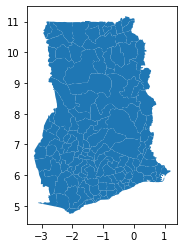

In [14]:
admin2_geopandas.plot()

In [18]:
event_counts_query = fc.location_event_counts(
    connection=conn,
    start_date="2016-01-01",
    end_date="2016-01-02",
    aggregation_unit="admin2",
    count_interval="day",
)

In [20]:
event_counts_query_result_dataframe = event_counts_query.get_result()
subscriber_counts_query_result_dataframe = subscriber_counts_query.get_result()

In [21]:
event_counts_query_result_dataframe

,pcod,date,value
0,GHA.10.10_1,2016-01-01,136103
1,GHA.10.1_1,2016-01-01,29092
2,GHA.10.11_1,2016-01-01,18329
3,GHA.10.12_1,2016-01-01,29829
4,GHA.10.13_1,2016-01-01,48162
...,...,...,...
132,GHA.9.5_1,2016-01-01,25780
133,GHA.9.6_1,2016-01-01,10862
134,GHA.9.7_1,2016-01-01,27528
135,GHA.9.8_1,2016-01-01,43417


In [22]:
event_counts_query_result_dataframe = event_counts_query_result_dataframe.rename(columns={"value": "event_count"})

In [16]:
subscriber_counts_query_result_dataframe

,pcod,value
0,GHA.10.10_1,64922
1,GHA.10.1_1,13965
2,GHA.10.11_1,9010
3,GHA.10.12_1,14396
4,GHA.10.13_1,22824
...,...,...
132,GHA.9.5_1,12638
133,GHA.9.6_1,5254
134,GHA.9.7_1,13289
135,GHA.9.8_1,20700


In [24]:
subscriber_counts_query_result_dataframe = subscriber_counts_query_result_dataframe.rename(columns={"value": "subscriber_count"})

In [25]:
joined_results = event_counts_query_result_dataframe.merge(subscriber_counts_query_result_dataframe, on="pcod")

In [26]:
joined_results

,pcod,date,event_count,subscriber_count
0,GHA.10.10_1,2016-01-01,136103,64922
1,GHA.10.1_1,2016-01-01,29092,13965
2,GHA.10.11_1,2016-01-01,18329,9010
3,GHA.10.12_1,2016-01-01,29829,14396
4,GHA.10.13_1,2016-01-01,48162,22824
...,...,...,...,...
132,GHA.9.5_1,2016-01-01,25780,12638
133,GHA.9.6_1,2016-01-01,10862,5254
134,GHA.9.7_1,2016-01-01,27528,13289
135,GHA.9.8_1,2016-01-01,43417,20700


In [27]:
joined_results["events_per_subscriber"] = joined_results["event_count"] / joined_results["subscriber_count"]
joined_results

,pcod,date,event_count,subscriber_count,events_per_subscriber
0,GHA.10.10_1,2016-01-01,136103,64922,2.096408
1,GHA.10.1_1,2016-01-01,29092,13965,2.083208
2,GHA.10.11_1,2016-01-01,18329,9010,2.034295
3,GHA.10.12_1,2016-01-01,29829,14396,2.072034
4,GHA.10.13_1,2016-01-01,48162,22824,2.110147
...,...,...,...,...,...
132,GHA.9.5_1,2016-01-01,25780,12638,2.039880
133,GHA.9.6_1,2016-01-01,10862,5254,2.067377
134,GHA.9.7_1,2016-01-01,27528,13289,2.071488
135,GHA.9.8_1,2016-01-01,43417,20700,2.097440


In [28]:
joined_results_with_geography = admin2_geopandas.merge(joined_results, on="pcod")

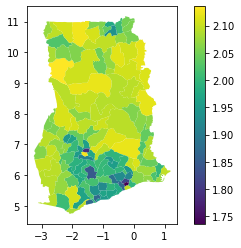

In [30]:
joined_results_with_geography.plot(column="events_per_subscriber", legend=True)

## "closing remarks"

- What have we learned?  
- In the next tutorial ([More complex queries](04-more-complex-queries.ipynb)) you will learn...